## 26/02/19

- Trying to improve peak detection algorithm using more heavy filtering (Butterworth filter). Peaks detected on convolved signals.

In [82]:
import sys
sys.path.insert(0, '/Users/matthewashman/github/MasterProject2018')

# Import necessary modules. Set settings. Import data.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pywt
from IPython.display import HTML
from FeatureExtraction.feature_tools import detect_peaks
from statsmodels.robust import mad
from scipy.interpolate import CubicSpline
from scipy.signal import butter, lfilter, freqz


from IPython.display import display, clear_output
import pdb

plt.style.use('default')

X = pd.read_pickle('/Users/matthewashman/github/MasterProject2018/Data/X_all_labels.pkl')

In [83]:
# Remove bad files with bad labels
X = X[~(X['CS1-2 Label']=='-1') & ~(X['CS3-4 Label']=='-1') & ~(X['CS5-6 Label']=='-1')]

In [84]:
def denoise(x):
    # Obtain Daubechies N=6 wavelet coefficients
    waveletCoefs = pywt.wavedec(x, 'db14', mode='per')

    # Throw away coefficients corresponding to noise
    sigma = mad(waveletCoefs[-1])
    uThresh = 2*sigma*np.sqrt(2*np.log(len(x)))
    denoised = waveletCoefs[:]
    denoised[1:] = (pywt._thresholding.hard(i, value=uThresh) for i in denoised[1:])

    # Reconstruct the original signal
    xDenoised = pywt.waverec(denoised, 'db14', mode='per')

    return xDenoised

def get_peaks(x, height_thresh, scale_amp=None, set_scale=False, plot = False):
    x = np.array(x)
    
    # Get height_thresh
    if set_scale:
        height_thresh = height_thresh*scale_amp
    else:
        height_thresh = height_thresh*max(abs(x))
    
    # Denoise x
    xdn = denoise(x)

    # Detect peaks using detect_peaks
    pos_peak_idx = detect_peaks(xdn, mph=height_thresh, threshold = 0)
    neg_peak_idx = detect_peaks((-xdn), mph=height_thresh, threshold = 0)
    peak_idx = np.concatenate([pos_peak_idx, neg_peak_idx])
    peak_idx = np.sort(peak_idx)
    # Edge indeces aren't detected
    peak_idx = peak_idx[(peak_idx != 0) & (peak_idx != (len(xdn)-1))]

    new_peak_idx = []
    peak_amp = []
    if (len(peak_idx) > 0):
        new_peak_idx.append(peak_idx[0])
        mp_thresh = 0.2*max(abs(x))
        for i in range(len(peak_idx)-1):
            idx = peak_idx[i]
            idx_next = peak_idx[i+1]
            mid_point = int((idx_next+idx)/2)
            if (max([abs(x[idx_next]-x[mid_point]), abs(x[idx]-x[mid_point])]) > mp_thresh):
                new_peak_idx.append(idx_next)

        peak_idx = np.array(new_peak_idx)
        peak_amp = x[peak_idx]

    if plot == True:
        fig, [ax1] = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,8))
        ax1.plot(x, 'b' , xdn, 'r--', peak_idx, peak_amp, 'kx')
        #plt.title(fileName)
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('Normalised amplitude')
        ax1.legend(['Original segment', 'Denoised segment', 'Detected peaks'])

        plt.draw()
        plt.waitforbuttonpress(0) # this will wait for indefinite time
        plt.close(fig)


    return peak_idx, peak_amp

In [100]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

test_data = X[X['S1/S2']=='S2'].iloc[263]['CS1-2']
filtered_data = butter_lowpass_filter(test_data, 10, 1000)

poly_coeffs = np.polyfit(np.arange(150), filtered_data, 2)
p = np.poly1d(poly_coeffs)

poly_fit = np.zeros(150)
for i in range(150):
    poly_fit[i] = p(i)

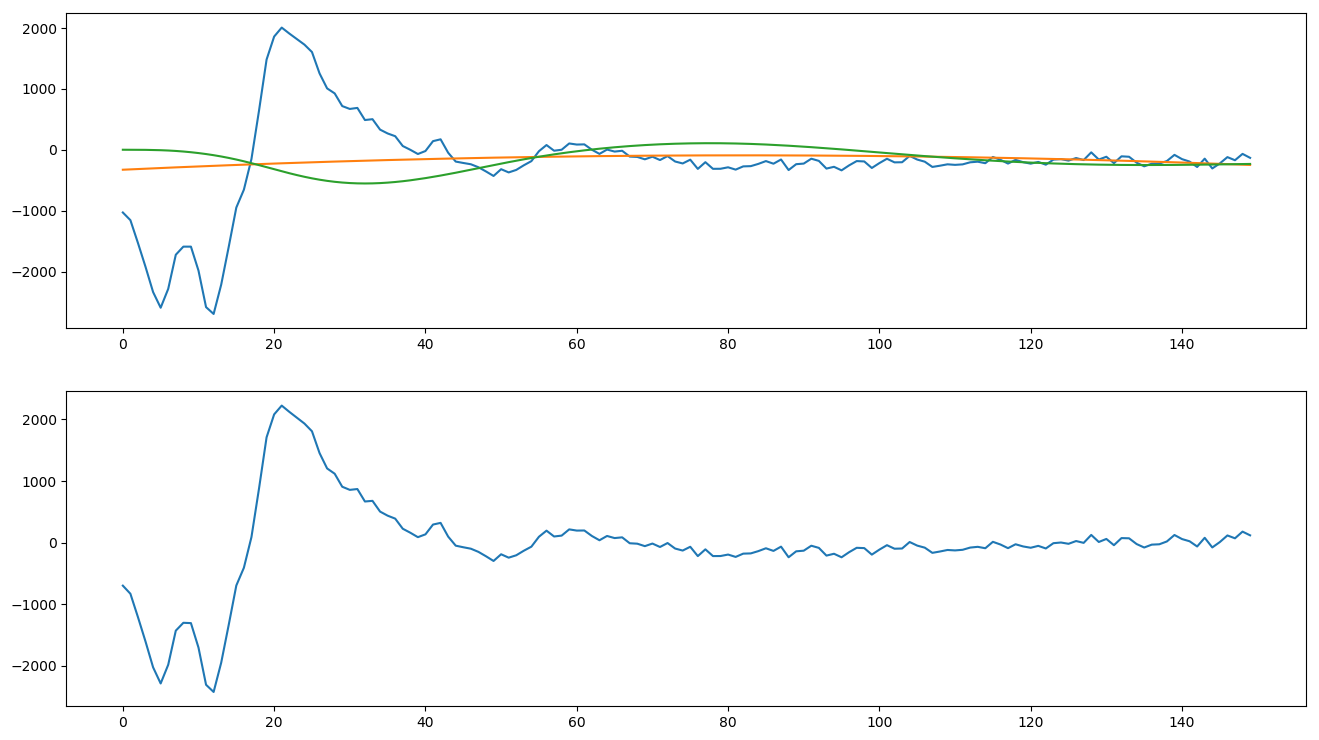

In [101]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16,9))
ax1.plot(range(150), test_data, range(150), poly_fit, range(150), filtered_data)
ax2.plot(range(150), (test_data-poly_fit))

plt.show()